In [247]:
import re
import numpy as np
import torch
import torch.autograd as ag
import torch.nn.functional as F
import torch.nn as nn
import torch.optim.lr_scheduler as lr_sch
import matplotlib.pyplot as plt
from time import clock

# Deep Learning for NLP - lab exercise 1

In this first lab exercise we will implement a simple bag-of-word classifier, i.e. a classifier that ignores the sequential structure of the sentence. The goal is to predict if a sentence is a positive or negative review of a movie. We will use a dataset constructed from IMDB.

1. Load and clean the data
2. Preprocess the data for the NN
3. Module definition
4. Train the network!

We will implement this model with Pytorch, the most popular deep learning framework for Natural Language Processing. You can use the following links for help:
* turorials: http://pytorch.org/tutorials/
* documentation: http://pytorch.org/docs/master/ 

**Hard deadline**: December 3, 2019


## Report

On top of this notebook, you must submit a report explaining your neural network, it's training method and report+analyse results, for example with different hyper-parameters (number of hidden layers, different embedding size, different hidden representation size, w or w/o dropout...you choose what you want to explore!).
You can also report results with different training dataset sizes (how does the number of training instances impact dev/test results? => *WARNING* obviously, here you change the training set size but you freeze the dev/test sets).

Training with the full dataset may be slow depending on your computer.

## Data

The data can be download here: http://teaching.caio-corro.fr/2019-2020/OPT7/imdb.zip

There are two files: one with positive reviews (imdb.pos) and one with negative reviews (imdb.neg). Each file contains 300000 reviews, one per line.


The following functions can be used to load and clean the data.

In [248]:
# Tokenize a sentence
def clean_str(string, tolower=True):
    """
    Tokenization/string cleaning.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    if tolower:
        string = string.lower()
    return string.strip()


# reads the content of the file passed as an argument.
# if limit > 0, this function will return only the first "limit" sentences in the file.
def loadTexts(filename, limit=-1):
    f = open(filename)
    dataset=[]
    line =  f.readline()
    cpt=1
    skip=0
    while line :
        cleanline = clean_str(f.readline()).split()
        if cleanline: 
            dataset.append(cleanline)
        else: 
            line = f.readline()
            skip+=1
            continue
        if limit > 0 and cpt >= limit: 
            break
        line = f.readline()
        cpt+=1        
        
    f.close()
    print("Load ", cpt, " lines from ", filename , " / ", skip ," lines discarded")
    return dataset


The following cell load the first 5000 sentences in each review set.

In [249]:
LIM=5000
txtfile = "imdb.pos"  # path of the file containing positive reviews
postxt = loadTexts(txtfile,limit=LIM)

txtfile = "imdb.neg"  # path of the file containing negative reviews
negtxt = loadTexts(txtfile,limit=LIM)

Load  5000  lines from  imdb.pos  /  1  lines discarded
Load  5000  lines from  imdb.neg  /  1  lines discarded


Split the data between train / dev / test, for example by creating lists txt_train, label_train, txt_dev, ... You should take care to keep a 50/50 ratio between positive and negative instances in each set.

In [98]:
txt = postxt + negtxt
label = list(np.ones(LIM, int))+list(np.zeros(LIM, int))

In [99]:
from sklearn.model_selection import train_test_split

txt_train, txt_dev, label_train, label_dev = train_test_split(txt, label, test_size=0.1, random_state=26 ,stratify=label)

txt_train, txt_test, label_train, label_test = train_test_split(txt_train , label_train , test_size=0.1, random_state = 26 , stratify=label_train)

# Converting data to Pytorch tensors

We will first convert data to Pytorch tensors so they can be used in a neural network.
To do that, you must first create a dictionnary that will map words to integers.
Add to the dictionnary only words that are in the training set (be sure to understand why we do that!).

Then, you can convert the data to tensors:
- use tensors of longs: both the sentence and the label will be represented as integers, not floats!
- these tensors do not require a gradient

A tensor representing a sentence is composed of the integer representation of each word, e.g. [10, 256, 3, 4].
Note that some words in the dev and test sets may not be in the dictionnary! (i.e. unknown words)
You can just skip them.

In [100]:
class Dict:
    def __init__(self, words, unk=None):
        self._unk = unk
        self._word_to_id = dict()
        self._id_to_word = list()

        if unk in words:
            raise RuntimeError("UNK word exists in vocabulary")

        if unk is not None:
            self.unk_index = self._add_word(unk)

        for word in words:
            self._add_word(word)

    # for internal use only!
    def _add_word(self, word):
        if word not in self._word_to_id:
            id = len(self._id_to_word)
            self._word_to_id[word] = id
            self._id_to_word.append(word)
            return id
        else:
            return self._word_to_id[word]

    def str_to_id(self, word):
        if self._unk is not None:
            return self._word_to_id.get(word, self.unk_index)
        else:
            return self._word_to_id[word]

    def id_to_str(self, id):
        return self._id_to_word[id]

    def __len__(self):
        return len(self._word_to_id)

    def has_unk(self):
        return self._unk is not None
    
    def unk(self):
        return self.unk_index

In [101]:
#Creating a dictionary where each word is associated to an index
word_index = {}
for sentence in txt_train:
    for word in sentence:
        if word not in word_index:
            word_index[word] = len(word_index) + 1
            

In [102]:
Dict_train_ = Dict(word_index, unk=True)

# Neural network definition

The neural network should be defined as follows:
- it takes as input a tensor that is a sequence of integers indexing word embeddings
- it retrieves the word embeddings from an embedding table
- it constructs the "input" of the MLP by summing over all embeddings (i.e. bag-of-word model)
- it build a hidden represention using a MLP (1 layer? 2 layers? experiment! but maybe first try wihout any hidden layer...)
- it project the hidden representation to the output space: it is a binary classification task, so the output space is a scalar where a negative (resp. positive) value means the review is negative (resp. positive).

In [103]:
class CBOW_classifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW_classifier, self).__init__()
        
        """
       A text classifier: 
       - input = a list of word indices 
       - output = probability associated to a binary classification task
       The pooling operation is the sum

       To build it, two args : 
       - vocab_size: the number of words in the vocabulary we want to embed
       - embedding_dim: size of the word vectors
        """
        # To create an embedding table: https://pytorch.org/docs/stable/nn.html#torch.nn.Embedding
        self.embeddings = nn.Embedding(num_embeddings = vocab_size, embedding_dim=embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, 1)
        
        # Parameter initialization
        nn.init.xavier_uniform_(self.linear1.weight.data)
        nn.init.zeros_(self.linear1.bias.data)
        
        #self.out = nn.Sigmoid() # because we'll use BCELoass : binary cross entropy
        
    def forward(self, inputs):
        # TODO
            inp = self.embeddings(inputs).sum(dim=0)
            return self.linear1(inp) 

## Loss function

Create a loss function builder.

- Pytorch loss functions are documented here: https://pytorch.org/docs/stable/nn.html#loss-functions
- In our case, we are interested in *BCELoss* and *BCEWithLogitsLoss*. Read their documentation and choose the one that fits with your network output

In [104]:
loss = nn.BCEWithLogitsLoss()

## Training loop

Write your training loop!

- parameterizable number of epochs
- at each epoch, print the mean loss and the dev accuracy

In [105]:
def train(model , epochs, X_train ,y_train , X_dev , y_dev , optimizer):   
        
    #variables to see the progression
    mean_loss_train = []
    mean_loss_dev = []
    acc_train = []
    acc_dev = []
    
    
    #passe le modele en mode training
    model.train()
    
    for i in range(epochs):
        #defining parameters to print the evolution of the NN
        accuracy = 0
        mean_loss = 0
        
        #shuffle to reduce overfitting
        d = list(zip(X_train, y_train))
        np.random.shuffle(d)
        X_train, y_train = zip(*d)
        
        for sentence,label in zip(X_train , y_train):
            
            # initialize the parameters gradient to zero
            optimizer.zero_grad()
            
            #Creating the tensors for inputs
            data = torch.LongTensor([Dict_train_.str_to_id(word) for word in sentence])
            label = torch.Tensor([label])
            #prediction and loss
            pred = model(data)
            loss_out = loss(pred , label)
            mean_loss+=loss_out.item()
            
            #Backward and updates
            loss_out.backward()
            optimizer.step()

            #Computing accuracy
        if (prediction >= 0.5 and label==1) or (prediction<0.5 and label==0):
                accuracy += 1
            
        mean_loss_train.append(mean_loss/len(X_train))
        accuracy_train.append(accuracy/len(X_train))
        
        print("EPOCH" , str(i+1) ,"On the training data : mean loss is :" , mean_loss/len(X_train) , "accuracy is: " ,accuracy/len(X_train))


        mean_loss = 0
        accuracy = 0
        
        #testing on dev data
        for sentence,label in zip(X_dev,y_dev):
            data = torch.LongTensor([Dict_train_.str_to_id(word) for word in sentence])
            label = torch.Tensor([label])
            
            #prediction and loss
            prediction = model(data)
            loss_out = loss(prediction , label)
            
            mean_loss+=loss_out.item()
            
            
            #computing accuracy
            if (prediction >= 0.5 and label==1) or (prediction < 0.5 and label==0):
                accuracy += 1
            
        print("EPOCH" , str(i+1) ,"On the dev data : mean loss is : " , mean_loss/len(X_dev) , " accuracy is : " ,accuracy/len(X_dev))
        print("----------------------------------------------------------------------------")
        mean_loss_dev.append(mean_loss/len(X_dev))
        acc_dev.append(accuracy/len(X_dev))
          
            
            
    #Plotting accuracy curves for dev and train data
    plt.figure()
    plt.plot(accuracy_train , label='Train')
    plt.plot(acc_dev, label="Dev")
    plt.title("Accuracy in term of epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    
    #Plotting loss curves for dev and train data
    plt.figure()    
    plt.plot(mean_loss_train , label='Train')
    plt.plot(mean_loss_dev, label="Dev")
    plt.title("Loss in term of epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    

In [106]:
#Calculating accuracy on test data
def test_accuracy(model,  X_test , y_test):
    
    accuracy = 0
    mean_loss = 0
        
    for sentence,label in zip(X_test,y_test):
        data = torch.LongTensor([Dict_train_.str_to_id(word) for word in sentence])
        label = torch.Tensor([label])
             
        prediction = model(data)
        loss_out = loss(prediction , label)
        mean_loss += loss_out.item()
                        
            
        #computing accuracy
        if (prediction >= 0.5 and label==1) or (prediction<0.5 and label==0):
            accuracy += 1

            
    print("Accuracy on test set for this model is" , accuracy/len(X_test))
    return(accuracy/len(X_test))

EPOCH 1 The mean loss in training data : 3.1948911305584247 Accuracy is :  0.6161728395061729
EPOCH 1 The mean loss in dev data  1.1989585479625293 Accuracy is :  0.658
----------------------------------------------------------------
EPOCH 2 The mean loss in training data : 0.6972672939888334 Accuracy is :  0.7180246913580247
EPOCH 2 The mean loss in dev data  0.6171848155984226 Accuracy is :  0.726
----------------------------------------------------------------
EPOCH 3 The mean loss in training data : 0.492425448965954 Accuracy is :  0.7693827160493827
EPOCH 3 The mean loss in dev data  0.5707604250350996 Accuracy is :  0.724
----------------------------------------------------------------
EPOCH 4 The mean loss in training data : 0.4633806975490103 Accuracy is :  0.7753086419753087
EPOCH 4 The mean loss in dev data  0.5118212757791243 Accuracy is :  0.73
----------------------------------------------------------------
EPOCH 5 The mean loss in training data : 0.4594847475090246 Accura

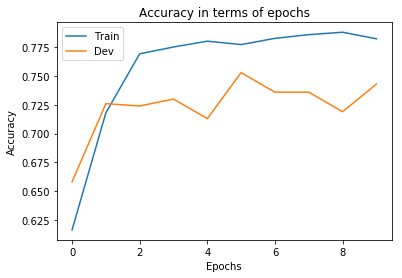

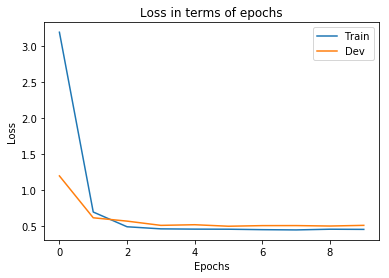

In [28]:
embedding_dim = 50
model_1 = CBOW_classifier (len(Dict_train_)+1, embedding_dim)
lr = 0.1
n_epochs = 10
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=lr, weight_decay=1e-3)
train(model_1, n_epochs, txt_train ,label_train, txt_dev, label_dev, optimizer)

In [29]:
test_accuracy(model_1,  txt_test , label_test)

Accuracy on test set for this model is 0.7411111111111112


### Remarks : 
1) The curve of the accuracy on the training data is globaly increasing in terms of epochs but it is fluctuente. To solve this problem we need to decrease the learning rate. Or decreasing this one is time consuming. Then adaptative learning optimizer seems a good solution to use. We will try then to training our model using the adaptative learning optimizer "Adam" and "AdaDelta". 

2) The curve of the accuracy on the validation data is globaly increasing in terms of epochs but it is fluctuente. This fluctuency is due to the overfitting of the model. To avoid this problem. We can try possible solutions like below : 

* obtain more data-points (or artificially expand the set of existing ones).
* play with hyper-parameters (embedding size, number of hidden layers).
* regularization: try dropout, early-stopping, so on.

Getting more training data is a good way to avoid overfitting whereas this solution is time consuming. For that reasons we will only try the two other solutions.



Optimizer :  1
EPOCH 1 On the training data : mean loss is : 1.0348448490874484 accuracy is:  0.5593827160493827
EPOCH 1 On the dev data : mean loss is :  1.0354150922811314  accuracy is :  0.589
----------------------------------------------------------------------------
EPOCH 2 On the training data : mean loss is : 0.9819201586004647 accuracy is:  0.5787654320987654
EPOCH 2 On the dev data : mean loss is :  0.9814877727784733  accuracy is :  0.565
----------------------------------------------------------------------------
EPOCH 3 On the training data : mean loss is : 0.9312021928544174 accuracy is:  0.5932098765432099
EPOCH 3 On the dev data : mean loss is :  0.8983026612653358  accuracy is :  0.574
----------------------------------------------------------------------------
EPOCH 4 On the training data : mean loss is : 0.8857175955560277 accuracy is:  0.6155555555555555
EPOCH 4 On the dev data : mean loss is :  0.88213334404114  accuracy is :  0.588
--------------------------------

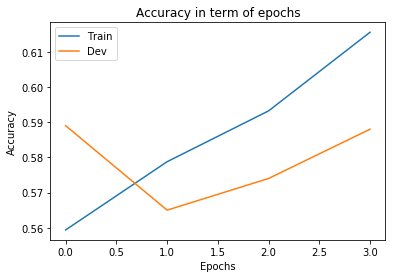

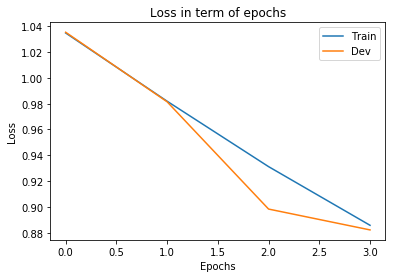

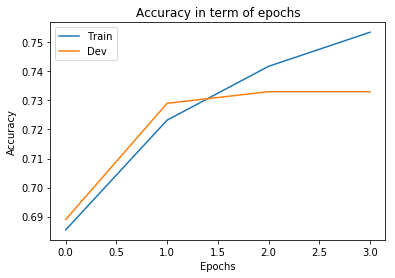

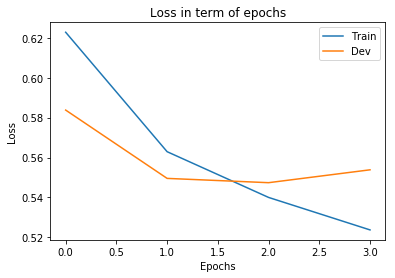

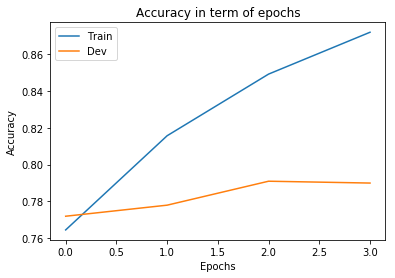

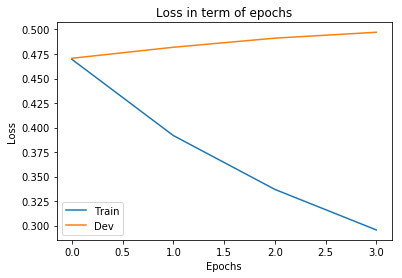

<Figure size 432x288 with 0 Axes>

In [111]:
embedding_dim = 50
model = CBOW_classifier(len(Dict_train_)+1, embedding_dim)
models = [model, model, model]
optimizers = [ 
    torch.optim.SGD(params=models[0].parameters(), lr=0.01, weight_decay=1e-4),
    torch.optim.Adadelta(params=models[1].parameters(), lr=1.0, rho=0.9, eps=1e-06),
    torch.optim.Adam(params=models[2].parameters())
]

accuracy = []
n_epochs = [4, 4, 4] # found these values doing preliminary tests
i = 0
for optimizer, n_epochs in zip(optimizers, n_epochs):
    print("Optimizer : ", i+1)
    start_time = clock()
    train(models[i], n_epochs, txt_train ,label_train, txt_dev, label_dev, optimizer) 
    print("Duration is ", clock() - start_time)
    accuracy.append(test_accuracy(models[i],  txt_test , label_test))
    i += 1

Text(0,0.5,'Accuracy')

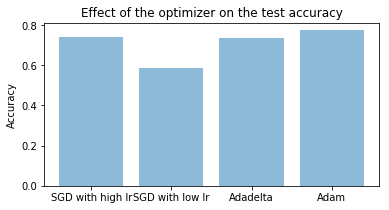

In [121]:
plt.figure(figsize=(6, 3))
plt.title("Effect of the optimizer on the test accuracy")
optimizer = ('SGD with high lr', 'SGD with low lr', 'Adadelta', 'Adam')
optimizer_index = np.arange(len(optimizer))

acc = [0.741] + accuracy # we already tried with SGD with high lr where we obtained accuracy = 0.741
plt.bar(optimizer_index, acc, align='center', alpha=0.5)
plt.xticks(optimizer_index, optimizer)
plt.ylabel('Accuracy')


Text(0,0.5,'times')

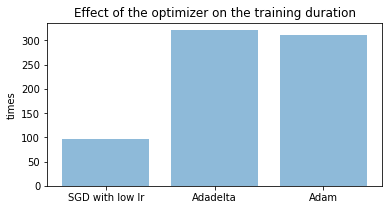

In [120]:
plt.figure(figsize=(6, 3))
plt.title("Effect of the optimizer on the training duration")
optimizer = ('SGD with low lr', 'Adadelta', 'Adam')
optimizer_index = np.arange(len(optimizer))

times = [95.60, 320.67092319999983, 311.1949010000001]
plt.bar(optimizer_index, times, align='center', alpha=0.5)
plt.xticks(optimizer_index, optimizer)
plt.ylabel('times')

### Hyperparameter : embedding size

EPOCH 1 On the training data : mean loss is : 0.7480287811536542 accuracy is:  0.5135802469135803
EPOCH 1 On the dev data : mean loss is :  0.6797653437703848  accuracy is :  0.527
----------------------------------------------------------------------------
EPOCH 2 On the training data : mean loss is : 0.6494684129877499 accuracy is:  0.5803703703703704
EPOCH 2 On the dev data : mean loss is :  0.6463814936690032  accuracy is :  0.604
----------------------------------------------------------------------------
EPOCH 3 On the training data : mean loss is : 0.5922598872588442 accuracy is:  0.6565432098765432
EPOCH 3 On the dev data : mean loss is :  0.6198032277664169  accuracy is :  0.662
----------------------------------------------------------------------------
EPOCH 4 On the training data : mean loss is : 0.5438898266791466 accuracy is:  0.7090123456790124
EPOCH 4 On the dev data : mean loss is :  0.5921140329703921  accuracy is :  0.686
---------------------------------------------

EPOCH 2 On the training data : mean loss is : 0.465680752244096 accuracy is:  0.7696296296296297
EPOCH 2 On the dev data : mean loss is :  0.5158682527687851  accuracy is :  0.754
----------------------------------------------------------------------------
EPOCH 3 On the training data : mean loss is : 0.38105415380420954 accuracy is:  0.8240740740740741
EPOCH 3 On the dev data : mean loss is :  0.5234183347564977  accuracy is :  0.757
----------------------------------------------------------------------------
EPOCH 4 On the training data : mean loss is : 0.3272361259247308 accuracy is:  0.8535802469135803
EPOCH 4 On the dev data : mean loss is :  0.5405035022144211  accuracy is :  0.76
----------------------------------------------------------------------------
EPOCH 5 On the training data : mean loss is : 0.2894035825062039 accuracy is:  0.8748148148148148
EPOCH 5 On the dev data : mean loss is :  0.5449423652505097  accuracy is :  0.77
-----------------------------------------------

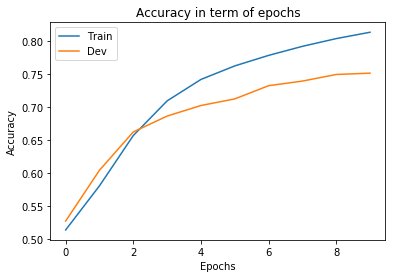

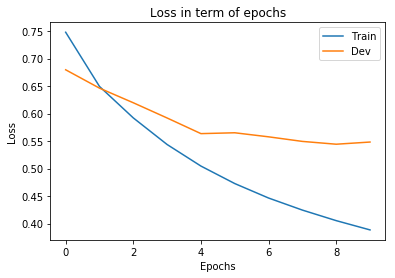

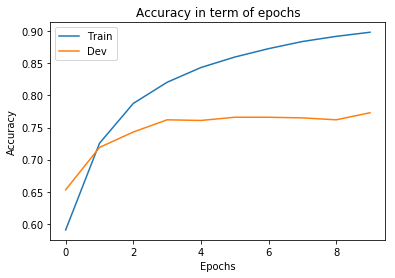

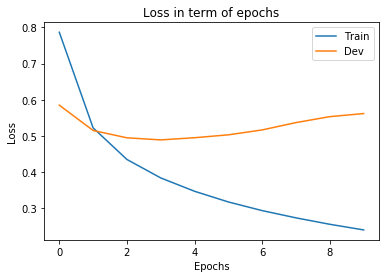

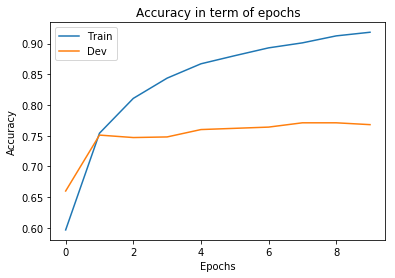

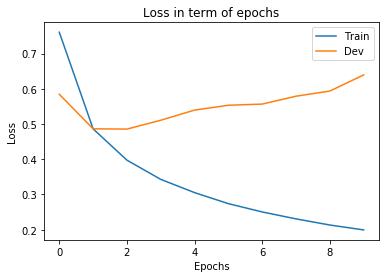

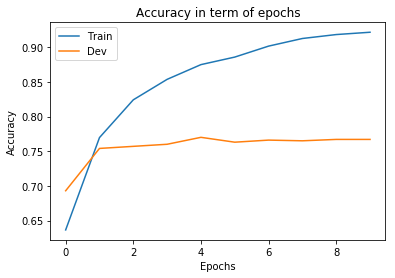

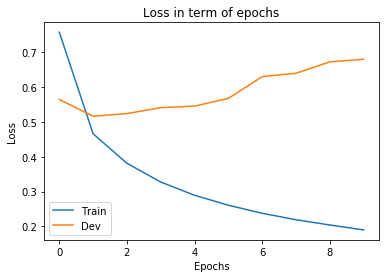

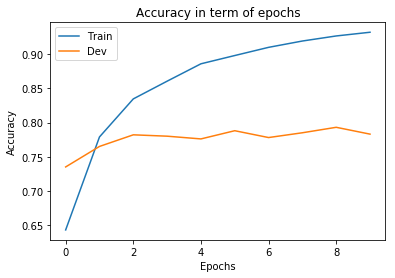

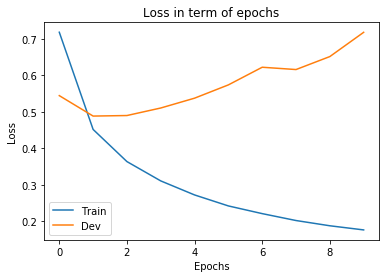

<Figure size 432x288 with 0 Axes>

In [126]:
accuracy = []
durations = []
dimensions = [1, 10, 20, 30, 60]
for embedding_dim in dimensions:
    model = CBOW_classifier(len(Dict_train_)+1, embedding_dim)
    n_epochs = 10
    optimizer = torch.optim.Adam(params=model.parameters()) 
    start_time = clock()
    train(model, n_epochs, txt_train, label_train, txt_dev, label_dev, optimizer)
    print("Duration is ", clock() - start_time)
    accuracy.append(test_accuracy(model, txt_test, label_test))

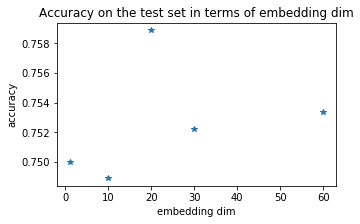

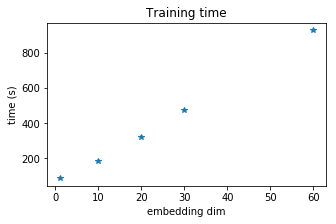

In [234]:
durations = [85.89051449999988, 187.4329472000004, 322.5501653000001, 473.0279228999998, 927.8146152999998]
accuracy = [ 0.75, 0.7488888888888889, 0.7588888888888888,0.7522222222222222,0.7533333333333333]
plt.figure(figsize=(5, 3))
plt.title("Accuracy on the test set in terms of embedding dim")
plt.plot(dimensions, accuracy, '*')
plt.ylabel('accuracy')
plt.xlabel('embedding dim')
plt.figure(figsize=(5, 3))
plt.ylabel("time (s)")
plt.xlabel('embedding dim')
plt.title("Training time")
plt.plot(dimensions,durations,'*')

 ### Network with hidden layers

In [153]:
class CBOW_classifier_one_hidden_layer(nn.Module):
    def __init__(self, vocab_size , embedding_dim):
        super(CBOW_classifier_one_hidden_layer, self).__init__()
        # To create an embedding table: https://pytorch.org/docs/stable/nn.html#torch.nn.Embedding
        self.embedding = torch.nn.Embedding(num_embeddings = vocab_size ,embedding_dim=embedding_dim)
        
        #1st hidden layer with 50 hidden unit
        self.hidden_1 = torch.nn.Linear(embedding_dim , 2)
        #ouput layer
        self.output = torch.nn.Linear(2,1)
        
        
        #initialisation
        torch.nn.init.xavier_uniform_(self.hidden_1.weight.data)
        torch.nn.init.zeros_(self.hidden_1.bias.data)
        
        torch.nn.init.xavier_uniform_(self.output.weight.data)
        torch.nn.init.zeros_(self.output.bias.data)
        
        
    def forward(self, inputs):
        
        x = self.embedding(inputs)
        x = torch.sum(x, dim=0)
        z = torch.tanh(self.hidden_1(x))

        return(self.output(z))        


EPOCH 1 On the training data : mean loss is : 0.662996789533415 accuracy is:  0.5855555555555556
EPOCH 1 On the dev data : mean loss is :  0.600331816226244  accuracy is :  0.651
----------------------------------------------------------------------------
EPOCH 2 On the training data : mean loss is : 0.5388606285570581 accuracy is:  0.7208641975308642
EPOCH 2 On the dev data : mean loss is :  0.5397354798614978  accuracy is :  0.701
----------------------------------------------------------------------------
EPOCH 3 On the training data : mean loss is : 0.45299841265251606 accuracy is:  0.7760493827160494
EPOCH 3 On the dev data : mean loss is :  0.5218213971629739  accuracy is :  0.721
----------------------------------------------------------------------------
EPOCH 4 On the training data : mean loss is : 0.3912607399861754 accuracy is:  0.8134567901234568
EPOCH 4 On the dev data : mean loss is :  0.503993304759264  accuracy is :  0.746
-----------------------------------------------

0.7666666666666667

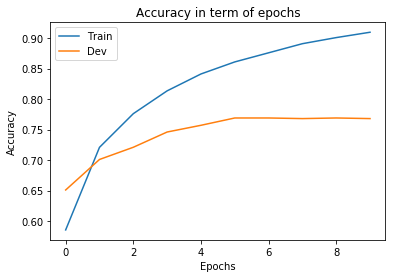

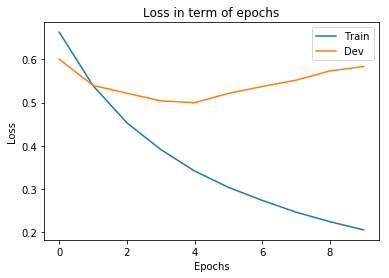

<Figure size 432x288 with 0 Axes>

In [155]:
loss = nn.BCEWithLogitsLoss()
embedding_dim = 20
hidden_layers_model = CBOW_classifier_one_hidden_layer(len(Dict_train_)+1, embedding_dim)
n_epochs = 10
optimizer = torch.optim.Adam(params=hidden_layers_model.parameters())
train(hidden_layers_model, n_epochs, txt_train, label_train, txt_dev, label_dev, optimizer)
test_accuracy(hidden_layers_model, txt_test , label_test)

In [237]:
class CBOW_classifier_two_hidden_layer(nn.Module):
    def __init__(self, vocab_size , embedding_dim):
        super(CBOW_classifier_two_hidden_layer, self).__init__()
        # To create an embedding table: https://pytorch.org/docs/stable/nn.html#torch.nn.Embedding
        self.embedding = torch.nn.Embedding(num_embeddings = vocab_size ,embedding_dim=embedding_dim)
        
        n_hidden = 10
        #1st hidden layer with 50 hidden unit
        self.hidden_1 = torch.nn.Linear(embedding_dim , n_hidden)
        #2end hidden layer with 50 hidden unit   
        self.hidden_2 = torch.nn.Linear(n_hidden , 2)
        
        #ouput layer
        self.output = torch.nn.Linear(2,1)
        
        
        #initialisation
        torch.nn.init.xavier_uniform_(self.hidden_1.weight.data)
        torch.nn.init.zeros_(self.hidden_1.bias.data)

        torch.nn.init.xavier_uniform_(self.hidden_2.weight.data)
        torch.nn.init.zeros_(self.hidden_2.bias.data)
        
        torch.nn.init.xavier_uniform_(self.output.weight.data)
        torch.nn.init.zeros_(self.output.bias.data)
        
        
    def forward(self, inputs):
        
        x = self.embedding(inputs)
        x = torch.sum(x, dim=0)
        z1 = torch.tanh(self.hidden_1(x))
        z2 = torch.tanh(self.hidden_2(z1))
        
        return(self.output(z2))        


EPOCH 1 On the training data : mean loss is : 0.6528488951424758 accuracy is:  0.6079012345679012
EPOCH 1 On the dev data : mean loss is :  0.6077352452725172  accuracy is :  0.668
----------------------------------------------------------------------------
EPOCH 2 On the training data : mean loss is : 0.5285830978423725 accuracy is:  0.7429629629629629
EPOCH 2 On the dev data : mean loss is :  0.5530527999699115  accuracy is :  0.71
----------------------------------------------------------------------------
EPOCH 3 On the training data : mean loss is : 0.440548387007029 accuracy is:  0.8061728395061728
EPOCH 3 On the dev data : mean loss is :  0.5266555563881993  accuracy is :  0.739
----------------------------------------------------------------------------
EPOCH 4 On the training data : mean loss is : 0.3719989005788977 accuracy is:  0.8446913580246913
EPOCH 4 On the dev data : mean loss is :  0.5364272586964071  accuracy is :  0.746
-----------------------------------------------

0.7444444444444445

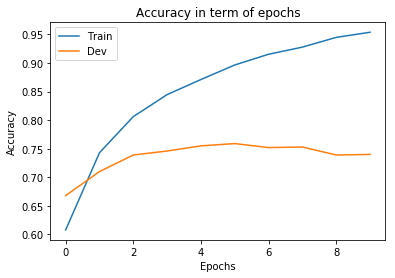

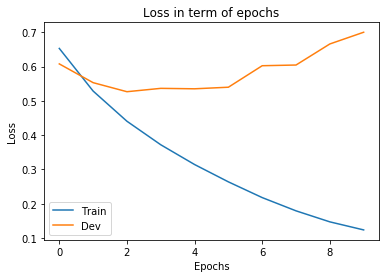

<Figure size 432x288 with 0 Axes>

In [239]:
loss = nn.BCEWithLogitsLoss()
embedding_dim = 20
hidden_layers_model_2 = CBOW_classifier_two_hidden_layer(len(Dict_train_)+1, embedding_dim)
n_epochs = 10
optimizer = torch.optim.Adam(params=hidden_layers_model_2.parameters())
train(hidden_layers_model_2, n_epochs, txt_train, label_train, txt_dev, label_dev, optimizer)
test_accuracy(hidden_layers_model_2, txt_test , label_test)

In [199]:
class CBOW_classifier_with_one_hidden_layer_and_dropout(nn.Module):
    def __init__(self, vocab_size, embedding_dim, dropout):
        super(CBOW_classifier_with_one_hidden_layer_and_dropout, self).__init__()
        # TODO
        # To create an embedding table: https://pytorch.org/docs/stable/nn.html#torch.nn.Embedding
        self.embedding = torch.nn.Embedding(num_embeddings = vocab_size ,embedding_dim=embedding_dim)
        
        #1st hidden layer with 50 hidden unit
        self.hidden_1 = torch.nn.Linear(embedding_dim , 2)
        #ouput layer
        self.output = torch.nn.Linear(2,1)
        
        self.dropout = nn.Dropout(p=dropout)
        
        #initialisation
        torch.nn.init.xavier_uniform_(self.hidden_1.weight.data)
        torch.nn.init.zeros_(self.hidden_1.bias.data)
        
        torch.nn.init.xavier_uniform_(self.output.weight.data)
        torch.nn.init.zeros_(self.output.bias.data)
        
        
    def forward(self, inputs):
        
        x = self.embedding(inputs)
        x = torch.sum(x, dim=0)
        x = self.dropout(x)
        z = torch.tanh(self.hidden_1(x))

        return(self.output(z))   

EPOCH 1 On the training data : mean loss is : 0.6583657936770239 accuracy is:  0.5725925925925925
EPOCH 1 On the dev data : mean loss is :  0.6185248773694039  accuracy is :  0.653
----------------------------------------------------------------------------
EPOCH 2 On the training data : mean loss is : 0.5435320490782644 accuracy is:  0.7167901234567902
EPOCH 2 On the dev data : mean loss is :  0.5627910759747028  accuracy is :  0.695
----------------------------------------------------------------------------
EPOCH 3 On the training data : mean loss is : 0.4574743795045364 accuracy is:  0.7706172839506172
EPOCH 3 On the dev data : mean loss is :  0.5378250138163566  accuracy is :  0.723
----------------------------------------------------------------------------
EPOCH 4 On the training data : mean loss is : 0.398858746389548 accuracy is:  0.8053086419753086
EPOCH 4 On the dev data : mean loss is :  0.5329112893790007  accuracy is :  0.75
-----------------------------------------------

EPOCH 2 On the dev data : mean loss is :  0.6849969183206558  accuracy is :  0.5
----------------------------------------------------------------------------
EPOCH 3 On the training data : mean loss is : 0.6833866969633986 accuracy is:  0.5
EPOCH 3 On the dev data : mean loss is :  0.6784930870831013  accuracy is :  0.5
----------------------------------------------------------------------------
EPOCH 4 On the training data : mean loss is : 0.675531290523064 accuracy is:  0.5330864197530865
EPOCH 4 On the dev data : mean loss is :  0.6749235306680202  accuracy is :  0.558
----------------------------------------------------------------------------
EPOCH 5 On the training data : mean loss is : 0.6665128516893328 accuracy is:  0.5806172839506173
EPOCH 5 On the dev data : mean loss is :  0.6655635474324226  accuracy is :  0.572
----------------------------------------------------------------------------
EPOCH 6 On the training data : mean loss is : 0.6547591995162728 accuracy is:  0.60555

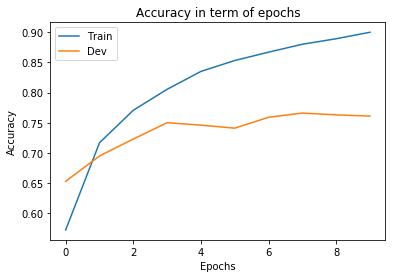

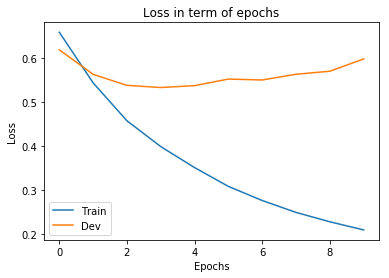

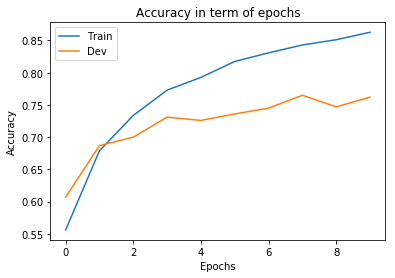

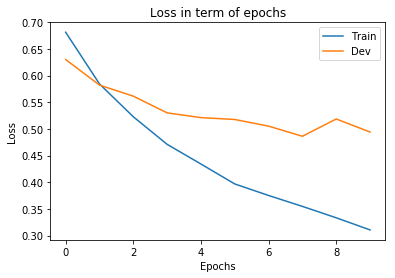

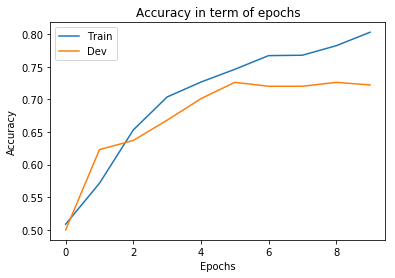

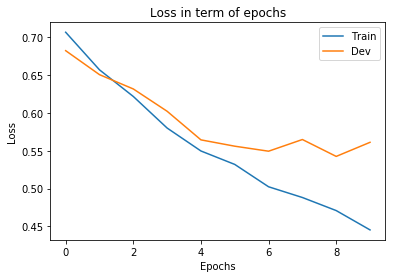

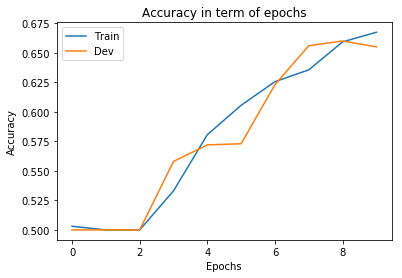

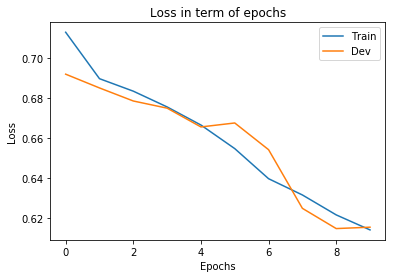

<Figure size 432x288 with 0 Axes>

In [226]:
dropouts = [0.0, 0.2, 0.5, 0.8]
durations = []
accuracy = []
for dropout in dropouts:
    embedding_dim = 20
    model_d = CBOW_classifier_with_one_hidden_layer_and_dropout(len(Dict_train_), embedding_dim, dropout)
    n_epochs = 10
    # we use Adam with default parameters because the learning rate should be higher for big dropout rates
    optimizer = torch.optim.Adam(params=model_d.parameters())
    start_time = clock()
    train(model_d, n_epochs, txt_train, label_train, txt_dev, label_dev, optimizer)
    durations.append(clock() - start_time)
    accuracy.append(test_accuracy(model_d, txt_test , label_test))

[0.7622222222222222, 0.7544444444444445, 0.7177777777777777, 0.6422222222222222]


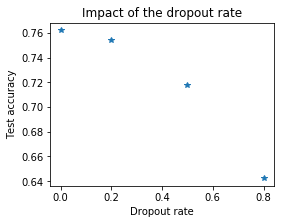

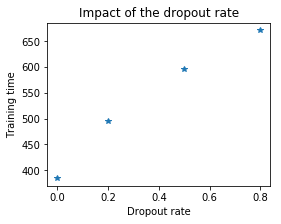

In [231]:
plt.figure(figsize=(4, 3))

plt.ylabel("Test accuracy")
plt.xlabel('Dropout rate')
plt.title("Impact of the dropout rate")
plt.plot(dropouts, accuracy,'*')

plt.figure(figsize=(4, 3))

plt.plot()
plt.ylabel("Training time")
plt.xlabel('Dropout rate')
plt.title("Impact of the dropout rate")
plt.plot(dropouts, durations,'*')

In [244]:
class CBOW_classifier_two_hidden_layer_and_dropout(nn.Module):
    def __init__(self, vocab_size , embedding_dim, dropout):
        super(CBOW_classifier_two_hidden_layer_and_dropout, self).__init__()
        # To create an embedding table: https://pytorch.org/docs/stable/nn.html#torch.nn.Embedding
        self.embedding = torch.nn.Embedding(num_embeddings = vocab_size ,embedding_dim=embedding_dim)
        
        n_hidden = 10
        #1st hidden layer with 50 hidden unit
        self.hidden_1 = torch.nn.Linear(embedding_dim , n_hidden)
        #2end hidden layer with 50 hidden unit   
        self.hidden_2 = torch.nn.Linear(n_hidden , 2)
        
        #ouput layer
        self.output = torch.nn.Linear(2,1)
        
        # dropouting function
        self.dropout = nn.Dropout(p=dropout)
        
        #initialisation
        torch.nn.init.xavier_uniform_(self.hidden_1.weight.data)
        torch.nn.init.zeros_(self.hidden_1.bias.data)

        torch.nn.init.xavier_uniform_(self.hidden_2.weight.data)
        torch.nn.init.zeros_(self.hidden_2.bias.data)
        
        torch.nn.init.xavier_uniform_(self.output.weight.data)
        torch.nn.init.zeros_(self.output.bias.data)
        
        
    def forward(self, inputs):
        
        x = self.embedding(inputs)
        x = torch.sum(x, dim=0)
        z1 = self.dropout(torch.tanh(self.hidden_1(x)))
        z2 = self.dropout(torch.tanh(self.hidden_2(z1)))
        
        return(self.output(z2))        


EPOCH 1 On the training data : mean loss is : 0.6646782116757499 accuracy is:  0.5750617283950618
EPOCH 1 On the dev data : mean loss is :  0.6043232718259096  accuracy is :  0.671
----------------------------------------------------------------------------
EPOCH 2 On the training data : mean loss is : 0.5354990092848922 accuracy is:  0.7274074074074074
EPOCH 2 On the dev data : mean loss is :  0.5423061060905456  accuracy is :  0.72
----------------------------------------------------------------------------
EPOCH 3 On the training data : mean loss is : 0.43440872889242055 accuracy is:  0.7987654320987654
EPOCH 3 On the dev data : mean loss is :  0.5263670535422862  accuracy is :  0.749
----------------------------------------------------------------------------
EPOCH 4 On the training data : mean loss is : 0.3519022534346139 accuracy is:  0.8453086419753086
EPOCH 4 On the dev data : mean loss is :  0.5283636422529817  accuracy is :  0.751
---------------------------------------------

EPOCH 2 On the dev data : mean loss is :  0.690566408932209  accuracy is :  0.503
----------------------------------------------------------------------------
EPOCH 3 On the training data : mean loss is : 0.6910706863579926 accuracy is:  0.501358024691358
EPOCH 3 On the dev data : mean loss is :  0.681705872297287  accuracy is :  0.514
----------------------------------------------------------------------------
EPOCH 4 On the training data : mean loss is : 0.6879137970194404 accuracy is:  0.5106172839506172
EPOCH 4 On the dev data : mean loss is :  0.6803304164707661  accuracy is :  0.517
----------------------------------------------------------------------------
EPOCH 5 On the training data : mean loss is : 0.6813230436341262 accuracy is:  0.5260493827160494
EPOCH 5 On the dev data : mean loss is :  0.67039732606709  accuracy is :  0.557
----------------------------------------------------------------------------
EPOCH 6 On the training data : mean loss is : 0.6747351684743239 accura

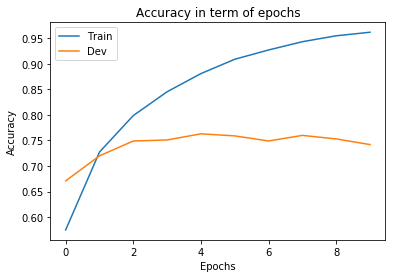

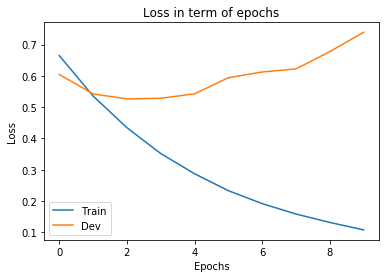

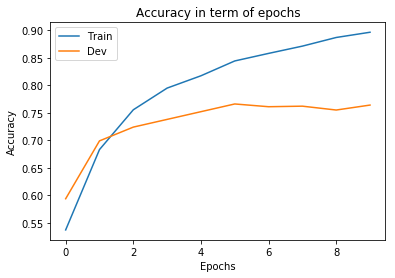

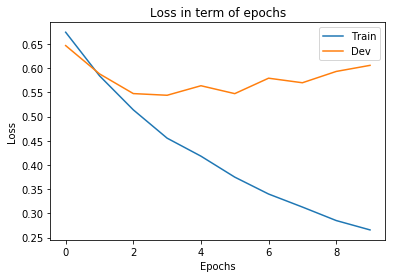

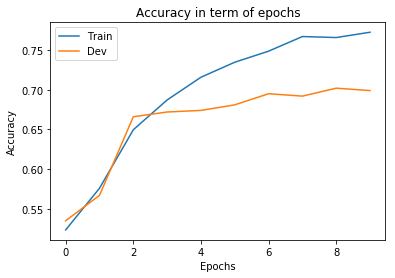

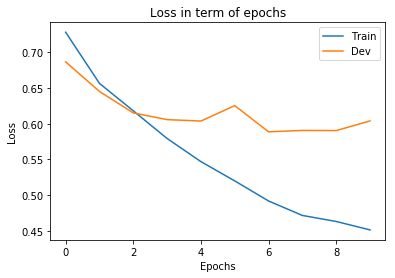

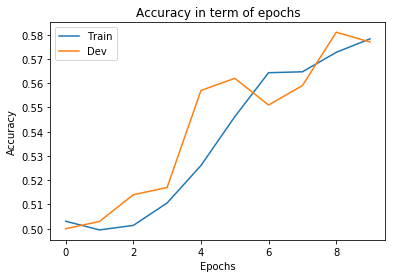

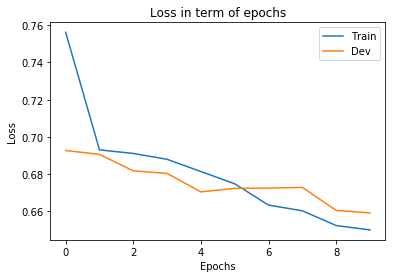

<Figure size 432x288 with 0 Axes>

In [245]:
dropouts = [0.0, 0.2, 0.5, 0.8]
durations = []
accuracy = []
embedding_dim = 20
for dropout in dropouts:
    model_d = CBOW_classifier_two_hidden_layer_and_dropout(len(Dict_train_), embedding_dim, dropout)
    n_epochs = 10
    # we use Adam with default parameters because the learning rate should be higher for big dropout rates
    optimizer = torch.optim.Adam(params=model_d.parameters())
    start_time = clock()
    train(model_d, n_epochs, txt_train, label_train, txt_dev, label_dev, optimizer)
    durations.append(clock() - start_time)
    accuracy.append(test_accuracy(model_d, txt_test , label_test))

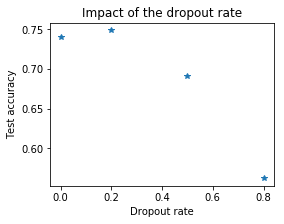

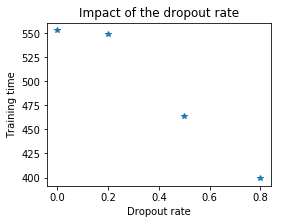

In [246]:
plt.figure(figsize=(4, 3))

plt.ylabel("Test accuracy")
plt.xlabel('Dropout rate')
plt.title("Impact of the dropout rate")
plt.plot(dropouts, accuracy,'*')

plt.figure(figsize=(4, 3))

plt.plot()
plt.ylabel("Training time")
plt.xlabel('Dropout rate')
plt.title("Impact of the dropout rate")
plt.plot(dropouts, durations,'*')

In [211]:
class CBOW_classifier_four_hidden_layer(nn.Module):
    def __init__(self, vocab_size , embedding_dim=100):
        super(CBOW_classifier_four_hidden_layer, self).__init__()
        # To create an embedding table: https://pytorch.org/docs/stable/nn.html#torch.nn.Embedding
        self.embedding = torch.nn.Embedding(num_embeddings = vocab_size ,embedding_dim=embedding_dim)
        
        #1st hidden layer with 50 hidden units
        self.hidden_1 = torch.nn.Linear(embedding_dim , 50)
        #2nd hidden layer with 40 hidden units
        self.hidden_2 = torch.nn.Linear(50 , 40)
        #3nd hidden layer with 30 hidden units
        self.hidden_3 = torch.nn.Linear(40 , 30)
        #4nd hidden layer with 30 hidden units
        self.hidden_4 = torch.nn.Linear(30 , 2)
        
        #ouput layer
        self.output = torch.nn.Linear(2,1)
        
        
        #initialisation
        torch.nn.init.xavier_uniform_(self.hidden_1.weight.data)
        torch.nn.init.zeros_(self.hidden_1.bias.data)
        
        torch.nn.init.xavier_uniform_(self.hidden_2.weight.data)
        torch.nn.init.zeros_(self.hidden_2.bias.data)
        
        torch.nn.init.xavier_uniform_(self.hidden_3.weight.data)
        torch.nn.init.zeros_(self.hidden_3.bias.data)
        
        torch.nn.init.xavier_uniform_(self.hidden_4.weight.data)
        torch.nn.init.zeros_(self.hidden_4.bias.data)
        
        torch.nn.init.xavier_uniform_(self.output.weight.data)
        torch.nn.init.zeros_(self.output.bias.data)
        
        
    def forward(self, inputs):
        
        x = self.embedding(inputs).sum(dim=0)
        z1 = torch.tanh(self.hidden_1(x))
        z2 = torch.tanh(self.hidden_2(z1))
        z3 = torch.tanh(self.hidden_3(z2))
        z4 = torch.tanh(self.hidden_4(z3))
        
        output = self.output(z4)
        
        return(output)

EPOCH 1 On the training data : mean loss is : 0.6409385825196902 accuracy is:  0.6293827160493827
EPOCH 1 On the dev data : mean loss is :  0.579976378172636  accuracy is :  0.701
----------------------------------------------------------------------------
EPOCH 2 On the training data : mean loss is : 0.5282917432818148 accuracy is:  0.7407407407407407
EPOCH 2 On the dev data : mean loss is :  0.5288118252754211  accuracy is :  0.734
----------------------------------------------------------------------------
EPOCH 3 On the training data : mean loss is : 0.4483909151335189 accuracy is:  0.7997530864197531
EPOCH 3 On the dev data : mean loss is :  0.49303907762467863  accuracy is :  0.767
----------------------------------------------------------------------------
EPOCH 4 On the training data : mean loss is : 0.38304428375705524 accuracy is:  0.8381481481481482
EPOCH 4 On the dev data : mean loss is :  0.5040033432990313  accuracy is :  0.777
--------------------------------------------

0.7411111111111112

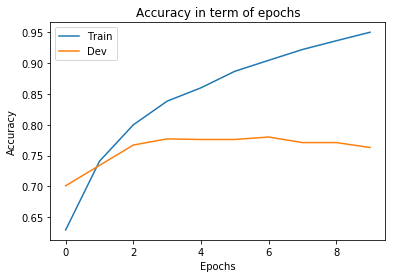

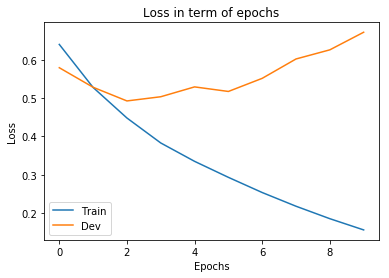

<Figure size 432x288 with 0 Axes>

In [212]:
loss = nn.BCEWithLogitsLoss()
embedding_dim = 20
four_hidden_layers_model = CBOW_classifier_four_hidden_layer(len(Dict_train_)+1, embedding_dim)
n_epochs = 10
optimizer = torch.optim.Adam(params=four_hidden_layers_model.parameters())
train(four_hidden_layers_model, n_epochs, txt_train, label_train, txt_dev, label_dev, optimizer)
test_accuracy(four_hidden_layers_model, txt_test , label_test)